# MTH3302 : Méthodes probabilistes et statistiques pour l'I.A.

Jonathan Jalbert<br/>
Professeur adjoint au Département de mathématiques et de génie industriel<br/>
Polytechnique Montréal<br/>


# TD2 - Régression linéaire

Ce TD concerne la régression linéaire (Chapitre 2 du cours). À la fin de ce TD, vous devriez être avoir été en mesure de
- Estimer les coefficients des paramères de régression avec la méthode des moindres carrés.
- Valider les hypothèses de la régression linéaire à l'aide de l'analyse des résidus.
- Tester l'importance de la régression.
- Calculer des intervalles de confiances sur les coefficients de régression ainsi que sur les prévisions.
- Vérifier la présence de multicolinéarité. 

Pour les deux premiers exercices, je vous suggère de ne utiliser la librairie GLM pour bien comprendre tous les concepts. La librairie GLM peut être utilisée pour le troisième exercice.

In [69]:
# Chargement des librairies
using CSV, DataFrames, Gadfly, Statistics, LinearAlgebra

# Exercice 1 - Pourcentage de gras

Le pourcentage de gras est un indice de forme physique d'un individu. Or, la mesure de cet indice est assez difficile. Elle requiert l'immersion complète de l'individu dans un cylindre gradué rempli d'eau. 

Par conséquent, on souhaite savoir si on peut prédire le pourcentage de gras $Y$ avec trois mesures beaucoup plus facile à obtenir :

$x_1$ : l'épaisseur des plis de la peau des triceps (en mm) ;<br/>
$x_2$ : le tour de cuisse (en mm) ;<br/>
$x_3$ : la circonférence du bras en (mm).<br/>

Les mesures du fichier *bodyfat.csv* proviennent de 20 femmes en bonne santé, âgées entre 20 et 34 ans. 

In [70]:
# Chargement des données
data = CSV.read("bodyfat.csv")
first(data,5)

,Triceps,Thigh,Midarm,Bodyfat
,Float64,Float64,Float64,Float64
1,19.5,43.1,29.1,11.9
2,24.7,49.8,28.2,22.8
3,30.7,51.9,37.0,18.7
4,29.8,54.3,31.1,20.1
5,19.1,42.2,30.9,12.9


## a) Affichage du pourcentage de graisse en fonction du tour de cuisse

Tracer le nuage de points du pourcentage de graisse en fonction de $x_2$, le tour de cuisse. Est-ce qu'une relation linéaire semble appropriée ?

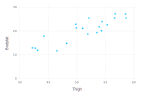

In [71]:
# Affichage lorsque les données sont dans un dataframe
plot(data, x=:Thigh, y=:Bodyfat, Geom.point)

## b) Estimation des paramètres de la régression linéaire simple

Estimez lez paramètres du modèle de régression linéaire entre le pourcentage de graisse et $x_2$, le tour de cuisse.

In [72]:
# Extraction des données dans des vecteurs
x = convert(Array{Float64},data[!,:Thigh])
y = convert(Array{Float64},data[!,:Bodyfat])

# Calcul des statistiques utiles
n = length(y)
x̄ = mean(x)
ȳ = mean(y)

# Calcul des coefficients de régression (pente et ordonnée à l'origine)
β̂₁ = sum( (x[i] - x̄)*(y[i] - ȳ) for i=1:n) / sum( (x[i] - x̄)^2 for i=1:n )
β̂₀ = ȳ - β̂₁*x̄

# Affichage des coefficients de régression
println("β̂₀ = $β̂₀")
println("β̂₁ = $β̂₁")


β̂₀ = -23.634489130309518
β̂₁ = 0.85654659234531


## c) Affichage de la droite de régression obtenue

Superposez au nuage de points précédent la droite de régression estimée. Pour ce faire, vous pouvez utiliser la commande `layer` de la librairie Gadfly.

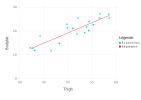

In [73]:
# Couche des données
sample = layer(data, x=:Thigh, y=:Bodyfat, Geom.point, Theme(default_color="deepskyblue"))

# droite de régression définie sur le domaine des données
xx = range(minimum(x),stop=maximum(x),length=10)
regression = layer(x=xx, y = β̂₀ .+ β̂₁*xx, Geom.line, Theme(default_color="red"))

plot(sample,regression,
    Guide.manual_color_key("Légende", ["Échantillon", "Régression"], ["deepskyblue","red"]))

## d) Calcul du $R^2$ ajusté et du $R^2$ de prévision.

Calculez pour le modèle de régression linéaire simple défini en (b) :
- le $R^2$ ajusté ;
- le $R^2$ de prévision.

In [74]:
# Calcul du R² ajusté

p = 1          # nombre de variables explicatives
n = length(y)  # taille de l'échantillon

ȳ = mean(y)
ŷ = β̂₀ .+ β̂₁*x
e = y - ŷ

SST = sum( (y[i] - ȳ)^2 for i=1:n )  # variabilité totale
SSE = sum( e.^2 )                    # variabilité due à l'erreur (résiduelle)

R2aj =  1 - SSE/SST * (n-1)/(n-p)

0.7710414083275696

In [75]:
# Calcul du R² de prévision

# matrice de structure
X = hcat(ones(n),x)

# Calcul de la matrice H pour la validation croisée
H = X/(X'*X)*X'

# Calcul des erreurs de validation croisée
ẽ = e./(1 .- diag(H))

# Calcul du coefficient de détermination de prévision
R2aj = 1-sum(ẽ.^2)/ SST

0.7286143986212001

## e) Vérification de la multicolinéarité 

Si toutes les variables explicatives sont utilisées, vérifiez s'il y a présence de multicolinéarité.

In [76]:
function check_multicol(X::Array{T,2} where T<:Real)
   
    # Attention, la matrice de structure X ne doit pas avoir une colonne de uns pour utiliser cette fonction
    n = size(X,1)
    if X[:,1] == ones(n)
        @error "Pour tester la multicolinéarité, la matrice de structure ne devrait pas avoir une colonne de 1."
    end
    
    # Standardisation des colonnes de X
    m = mean(X, dims=1)
    s = std(X, dims=1)
    
    X̃ = (X .- m) ./s
    
    # Calcul des valeurs singulières
    λ = svdvals(X̃)
    # Calculer les valeurs singulières de X est plus efficace que calculer les valeurs propres de X'X
    
    # Calcul de l'indice de multicolinéarité
    ϕ = maximum(λ) / minimum(λ)
    
    if ϕ > 30
        multicol = true
    else
        multicol = false
    end
    
    return multicol
end

check_multicol (generic function with 1 method)

In [77]:
data = CSV.read("bodyfat.csv")

x₁ = convert(Array{Float64},data[!,:Triceps])
x₂ = convert(Array{Float64},data[!,:Thigh])
x₃ = convert(Array{Float64},data[!,:Midarm])
y = convert(Array{Float64},data[!,:Bodyfat])

n = length(y)
X = hcat(ones(n),x₁,x₂,x₃)

# On teste la multicolinéarité sans la colonne de 1 de la matrice de structure
multicol = check_multicol(X[:,2:end])

if multicol
    println("Il y a présence de multicolinéarité.")
else
    println("Il n'y a pas de multicolinéarité.")
end

Il y a présence de multicolinéarité.


## f) Régression avec l'épaisseur du pli du triceps et la circonférence du bras

Estimez les paramètres du modèle de régression utilisant l'épaisseur du pli du triceps et la circonférence du bras comme variables explicatives.

In [78]:
x₁ = convert(Array{Float64},data[!,:Triceps])
x₂ = convert(Array{Float64},data[!,:Thigh])
x₃ = convert(Array{Float64},data[!,:Midarm])
y = convert(Array{Float64},data[!,:Bodyfat])
n = length(y)

X = hcat(ones(n),x₁,x₃)

β̂ = (X'X)\X'y

println("Les estimations des coefficient de régression sont β̂ = $(β̂)")


Les estimations des coefficient de régression sont β̂ = [6.7916274124420175, 1.0005849091217052, -0.43144201802196813]


## g) Validation des hypothèses de la régression

Tracez les résidus en fonction des prévisions. Est-ce que les hypothèses de la régression semblent satisfaites ?

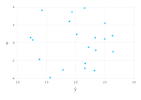

In [79]:
# Calcul des prévisions aux points observés
ŷ = X*β̂

# calcul des résidus
e = y - ŷ

plot(x = ŷ, y=e, Geom.point, Guide.xlabel("ŷ"), Guide.ylabel("e"))


## h) Calul du $R^2$ ajusté et du $R^2$ de prévision.

Calculez pour le modèle de régression linéaire simple défini en (f) :
- le $R^2$ ajusté ;
- le $R^2$ de prévision.

In [80]:
# Calcul du R² ajusté

p = 2          # nombre de variables explicatives
n = length(y)  # taille de l'échantillon

ȳ = mean(y)
ŷ = X*β̂
e = y - ŷ

SST = sum( (y[i] - ȳ)^2 for i=1:n )  # variabilité totale
SSE = sum( e.^2 )                    # variabilité résiduelle

R2aj =  1 - SSE/SST * (n-1)/(n-p)

0.7742798394106004

In [81]:
# Calcul du R² de prévision

# Calcul de la matrice H pour la validation croisée
H = X/(X'*X)*X'

# Calcul des erreurs de validation croisée
ẽ = e./(1 .- diag(H))

# Calcul du coefficient de détermination de prévision
R2aj = 1-sum(ẽ.^2)/ SST

0.7005720068318496

## i) Sélection de modèle

Lequel des modèles définis en (b) et (f) est le meilleur ? Justifiez.

# Exercice 2 - Notes de MTH2302B


Le jeu de données *notes.csv}* compile les notes obtenues aux deux contrôles périodiques et au final des 91 étudiants inscrits dans mes sections du cours MTH2302B pour les sessions A2017 et H2018. Durant la session d'automne, la majorité des étudiants provenait de génie chimique et génie biomédical tandis qu'à la session d'hiver, les étudiant provenaient majoritairement de génie mécanique et de génie aérospatial.

On souhaite déterminer s'il existe une relation linéaire entre la note au final ($Y$) et la note au premier contrôle ($X_1$) et la note au deuxième contrôle ($X_2$).


In [14]:
# Chargement des librairies
using CSV, DataFrames, Gadfly, Statistics, LinearAlgebra, Distributions

In [15]:
# Chargement des données
data = CSV.read("notes.csv")
first(data,5)

,CP1,CP2,Final,Session
,Float64,Float64,Float64,String
1,13.75,16.5,27.75,A2017
2,9.5,11.5,14.25,A2017
3,11.0,10.25,22.75,A2017
4,10.75,13.0,26.0,A2017
5,10.75,6.5,22.0,A2017


## a) Estimation des paramètres du modèle de régression

Estimez les paramètres du modèle de régression :
$$Y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \epsilon.$$

In [16]:
x₁ = convert(Array{Float64},data[!,:CP1])
x₂ = convert(Array{Float64},data[!,:CP2])
y = convert(Array{Float64},data[!,:Final])
n = length(y)

X = hcat(ones(n), x₁, x₂)

β̂ = (X'X)\X'y

println("Les estimations des coefficient de régression sont β̂ = $(β̂)")

Les estimations des coefficient de régression sont β̂ = [12.224032934946086, 0.31297174542620615, 0.6112804788597583]


## b) Validation des hypothèses de la régression

Validez les hypothèses de la régression avec le graphique des résidus

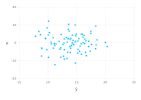

In [17]:
# Prévisions aux points observés
ŷ = X*β̂

# calcul des résidus
e = y - ŷ

plot(x = ŷ, y=e, Geom.point, Guide.xlabel("ŷ"), Guide.ylabel("e"))

## c) Test sur l'importance de la régression

Testez au seuil de 5% si au moins une des variables explicatives possède un pouvoir prédictif significatif.

In [85]:
ȳ = mean(y)

p = size(X,2)-1

#println("p = $p")

SST = sum( (y[i] - ȳ)^2 for i=1:n )  # variabilité totale
SSE = sum(e.^2)                      # variabilité résiduelle
SSR = SST - SSE

# Statistique du test
F₀ = SSR/SSE * (n-p-1)/p

# Distribution si l'hypothèse nulle est vraie
pd = FDist(p, n-p-1) 

# seuil du test
α = 0.05

# calcul de la probabilité d'observer une statistique plus extrême que celle obtenue
seuil_observe = ccdf(pd,F₀) # la fonction ccdf correspond à 1-cdf()

if seuil_observe < α
    println("La régression est significative au seuil de $α car le seuil observé du test est plus petit que α.
        On a en effet que seuil observé = $seuil_observe < $α")
else
    println("La régression n'est pas significative au seuil de $α car le seuil observé du test est plus grand que α.
        On a en effet que seuil observé = $seuil_observe > $α")
end


La régression est significative au seuil de 0.05 car le seuil observé du test est plus petit que α.
        On a en effet que seuil observé = 2.021895311507626e-6 < 0.05


## d) Est-ce que la session à laquelle les étudiants étaient inscrits joue un rôle  significatif ?

In [19]:
x₁ = convert(Array{Float64},data[!,:CP1])
x₂ = convert(Array{Float64},data[!,:CP2])
y = convert(Array{Float64},data[!,:Final])
n = length(y)

# Encodage de la session dans une variable catégorielle
x₃ = zeros(n)
ind = data[!,:Session] .== "H2018"
x₃[ind] .= 1;

X = hcat(ones(n), x₁, x₂, x₃)

β̂ = (X'X)\X'y

println("Les estimations des coefficient de régression sont β̂ = $(β̂)")

Les estimations des coefficient de régression sont β̂ = [13.706094637032312, 0.32186037955603636, 0.6137879296359798, -2.684850769519379]


In [20]:
# Calcul de l'intervalle de confiance de β₃

# nombre de variables explicatives
p = size(X,2)-1

# Calcul des résidus (erreurs observés)
e = y-X*β̂

# Estimation de la variance de l'erreur
σ̂² = 1/(n-p-1)*sum( e.^2 )

# calcul du quantile de la loi de Student
tₐ = cdf(TDist(n-p-1),.975)

# Calcul de l'inverse de la matrice de X'X
C = inv(X'X)

se = tₐ*sqrt(σ̂²*C[4,4])

println("L'intervalle de confiance de β₃ est [$(β̂[4] - se) , $(β̂[4] + se)")

L'intervalle de confiance de β₃ est [-3.53395352978958 , -1.8357480092491776


## e) Prévision de la note au final.

Supposons qu'un étudiant ait obtenu les notes de $13/20$ et de $15/20$ respectivement aux deux premiers contrôles périodiques:

 - $x_1 = 13/20$;
 - $x_2 = 15/20$.

Obtenez les estimations de sa note au final s'il était inscrit à la session A2017 et s'il était inscrit à la session H2018.

In [21]:
# Prévision si l'étudiant est inscrit à la session A2017
x₀ = [1.0 13/20 15/20 0.0]
Y₀ = x₀*β̂
println("L'estimation de sa note au final s'il était inscrit à la session A2017 est de $(Y₀[1]).")


# Prévision si l'étudiant est inscrit à la session A2017
x₀ = [1.0 13/20 15/20 1.0]
Y₀ = x₀*β̂
println("L'estimation de sa note au final s'il était inscrit à la session H2018 est de $(Y₀[1]).")

L'estimation de sa note au final s'il était inscrit à la session A2017 est de 14.375644830970721.
L'estimation de sa note au final s'il était inscrit à la session H2018 est de 11.690794061451342.


# Exercice 3 - Résistance au cisaillement

Le jeu de données *visco.csv* contient la résistance au cisaillement (en kPa) d'un composé de caoutchouc en fonction de la température de durcissement (en degré Celcius). 

Pour cet exercice, utilisez la librairie GLM.

In [22]:
using CSV, DataFrames, Gadfly, Statistics, LinearAlgebra, GLM

In [23]:
# chargement des données
data = CSV.read("viscosite.csv")

,Temperature,Resistance
,Int64,Int64
1,138,5309
2,140,5516
3,144,5792
4,146,5585
5,148,5068
6,152,4413
7,153,4068
8,157,3861


## a) Affichage de la résistance au cisaillement en fonction de la température

Affichez la résistance au cisaillement en fonction de la température.

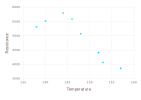

In [24]:
plot(data, x=:Temperature, y=:Resistance, Geom.point)

## b) Estimez les paramètres du modèle linéaire et calculez le $R^2$ ajusté

In [25]:
rename!(data, :Temperature => :T)

M₁ = lm(@formula(Resistance ~ T), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Resistance ~ 1 + T

Coefficients:
──────────────────────────────────────────────────────────────────────────────
               Estimate  Std. Error   t value  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────
(Intercept)  19166.6       3495.66    5.48297    0.0015  10613.0    27720.2   
T              -96.5373      23.719  -4.07003    0.0066   -154.576    -38.4989
──────────────────────────────────────────────────────────────────────────────

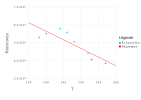

In [26]:
# couche du graphique pour les observations
sample = layer(data, x=:T, y=:Resistance, Geom.point, Theme(default_color="deepskyblue"))

# couche du graphique pour la droite de régression
x = collect(135:160)
X = hcat(ones(length(x)),x)
ŷ = predict(M₁,X)
regression = layer(x=x, y = ŷ, Geom.line, Theme(default_color="red"))

# Traçage du graphique
plot(sample,regression ,
    Guide.manual_color_key("Légende", ["Échantillon", "Régression"], ["deepskyblue","red"]))

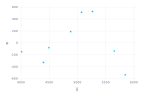

In [27]:
ŷ = predict(M₁)
e = residuals(M₁)

plot(x = ŷ, y=e, Geom.point, Guide.xlabel("ŷ"), Guide.ylabel("e"))

In [28]:
n = length(e)
p = n - dof_residual(M₁) - 1

y = data[:,:Resistance]
ȳ = mean(y)

SST = sum( (y[i] - ȳ)^2  for i=1:n )
SSE = sum(e.^2)

R2aj = 1 - SSE/SST * (n-1)/(n-p)

0.7341035339029551

## c) Estimez les paramètres du modèle quadratique et calculez le $R^2$ ajusté

In [29]:
data[!, :T2] = data[:, :T].^2

M₂ = lm(@formula(Resistance ~ T + T2), data)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Resistance ~ 1 + T + T2

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                 Estimate   Std. Error   t value  Pr(>|t|)    Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)    -1.48395e5  66815.7      -2.22096    0.0770    -3.2015e5  23360.1     
T            2182.9          908.436     2.40292    0.0614  -152.308      4518.11    
T2             -7.73865        3.08357  -2.50964    0.0539   -15.6652        0.187905
─────────────────────────────────────────────────────────────────────────────────────

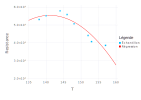

In [30]:
# couche du graphique pour les observations
sample = layer(data, x=:T, y=:Resistance, Geom.point, Theme(default_color="deepskyblue"))

# couche du graphique pour la droite de régression
x = collect(135:160)
X = hcat(ones(length(x)),x,x.^2)
ŷ = predict(M₂,X)
regression = layer(x=x, y = ŷ, Geom.line, Theme(default_color="red"))

# Traçage du graphique
plot(sample,regression ,
    Guide.manual_color_key("Légende", ["Échantillon", "Régression"], ["deepskyblue","red"]))

In [31]:
n = length(e)
p = n - dof_residual(M₂) - 1
e = residuals(M₂)

y = data[:,:Resistance]
ȳ = mean(y)

SST = sum( (y[i] - ȳ)^2  for i=1:n )
SSE = sum(e.^2)

R2aj = 1 - SSE/SST * (n-1)/(n-p)

0.8627173272489895

## d) Estimez les paramètres du modèle cubique et calculez le $R^2$ ajusté

In [32]:
data[!, :T3] = data[:, :T].^3

M₃ = lm(@formula(Resistance ~ T + T2 + T3), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Array{Float64,1}},GLM.DensePredChol{Float64,Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Resistance ~ 1 + T + T2 + T3

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                 Estimate     Std. Error   t value  Pr(>|t|)      Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)     -4.2644e6      8.27484e5  -5.15346    0.0067     -6.56187e6    -1.96694e6
T            86078.6       16861.1         5.10516    0.0070  39264.6           1.32893e5
T2            -577.139       114.415      -5.04427    0.0073   -894.805      -259.473    
T3               1.28681       0.258554    4.97695    0.0076      0.568948      2.00467  
─────────────────────────────────────────────────────────────────────────────────────────

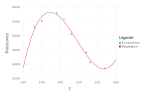

In [33]:
# couche du graphique pour les observations
sample = layer(data, x=:T, y=:Resistance, Geom.point, Theme(default_color="deepskyblue"))

# couche du graphique pour la droite de régression
x = collect(135:160)
X = hcat(ones(length(x)), x, x.^2, x.^3)
ŷ = predict(M₃,X)
regression = layer(x=x, y = ŷ, Geom.line, Theme(default_color="red"))

# Traçage du graphique
plot(sample,regression ,
    Guide.manual_color_key("Légende", ["Échantillon", "Régression"], ["deepskyblue","red"]))

In [34]:
n = length(e)
p = n - dof_residual(M₃) - 1
e = residuals(M₃)

y = data[:,:Resistance]
ȳ = mean(y)

SST = sum( (y[i] - ȳ)^2  for i=1:n )
SSE = sum(e.^2)

R2aj = 1 - SSE/SST * (n-1)/(n-p)

0.9770957058876237